In [2]:
import pandas as pd
import numpy as np
import sklearn.metrics as met
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import glob
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
import pickle
import FinanceDataReader as fdr

In [3]:
def get_data(df,window,y_window):
    y_MA=df[['Close']].rolling(y_window).mean()
    y_MA.iloc[0]=df['Close'].iloc[0]
    y_MA=y_MA.interpolate(limit_direction='backward')
    Y_df=y_MA.pct_change(window).shift(-window).dropna(axis=0)
    Y_df.columns = ['y_val']
    label_df = pd.DataFrame(np.where(y_MA.pct_change(window).shift(-window).dropna(axis=0)>0,1,0),
                            index=df.iloc[:-window].index,columns=['label'])
    Y_df.columns = ['label']
    feature_df = pd.DataFrame()
 
    for i in [5,10,20,40,60]:
        feature_df['Change_{}'.format(i)] = df['Close'].pct_change(i)
    for i in [5,10,20,40,60]:
        feature_df['MA_{}'.format(i)] = df['Close'].rolling(i).mean()
    for i in [60,120,252]:
        feature_df['HV_{}'.format(i)] = df['Change'].rolling(i).std()*(252**0.5)
    feature_df['Volume'] = df['Volume']
    feature_df = feature_df.dropna(axis=0)
 
    inter_index = feature_df.index & Y_df.index & label_df.index
    feature_df = feature_df.loc[inter_index]
    Y_df = Y_df.loc[inter_index]
    label_df = label_df.loc[inter_index]

    return feature_df,Y_df,label_df

In [4]:
def modeling(x_data,y_data,window,start_day):

    y_name = 'label'
    train_day = x_data.iloc[:len(x_data.loc[:start_day])-window].index[-1]
    pred_df = pd.DataFrame(index = x_data.index, columns = [y_name])

    model = RandomForestClassifier(n_estimators=100,n_jobs=-1)
    model.fit(x_data.loc[:start_day],y_data[y_name].loc[:start_day])
    pred_df[y_name].loc[:start_day] = list(model.predict(x_data.loc[:start_day]))



    for i in range(len(x_data.loc[:train_day]),len(x_data)-window):
        pred_df[y_name].loc[x_data.iloc[i+window:i+window+1].index[0]] = model.predict(x_data.iloc[i+window:i+window+1])[0]
        model.fit(x_data.iloc[:i+1],y_data[y_name].iloc[:i+1])

    return pred_df[pred_df.columns[0]]

In [5]:
def precision_condition2(true, pred, tol_1, tol_2, window, precision_window):
    tol_1 = round(tol_1,2)
    tol_2 = round(tol_2,2)
    df = pd.Series(name = 'FI')


    for i in range((precision_window+window),len(true)):
        val_1 = met.precision_score(true.iloc[(i-precision_window-window):(i-window)],
                                  pred.iloc[(i-precision_window-window):(i-window)],labels=[1,0])
        val_2 = met.confusion_matrix(true.iloc[(i-precision_window-window):(i-window)],
                          pred.iloc[(i-precision_window-window):(i-window)],labels=[1,0])
        val_2 = 0.01 if val_2[1,1]==0 else val_2[1,1]/(val_2[0,1] + val_2[1,1])
        if val_1 > tol_1 and val_2 < tol_2:
        #if val_2 < tol_2:
            df.loc[pred.iloc[i:i+1].index[0]] = 1
        else:
            df.loc[pred.iloc[i:i+1].index[0]] = pred.iloc[i]

    df = df.astype(int)
    
    return df

In [6]:
def make_return_value(result_data):
    df=pd.Series(index=result_data.index)
    for i in range(0,len(result_data),window):
        if len(result_data.iloc[i:i+window]) < window:
            pass
        else:
            temp=sum(result_data.iloc[i:i+window]*[i/sum(range(window)) for i in range(window)])
            if temp>=0.5:
                df.iloc[i+window-1]=1
            else:
                df.iloc[i+window-1]=0
    return df.ffill().dropna(axis=0)

In [7]:
def main(window,start_day,precision_window,y_window,tol1,tol2):
    
    accuracy_score=pd.DataFrame(columns=['non','FI'])
    F1_score=pd.DataFrame(columns=['non','FI'])
    return_score=pd.DataFrame(columns=['bench','non','FI'])
    
    #for ticker in ['HSI','IRTS','KQ11','KS11','NDX','SPY','SSEC','STOXX50']:
    for ticker in ['KQ11']:
        data=fdr.DataReader(ticker,'2011-01-01') #직접 바꿨음
        feature_df,Y_df,label_df = get_data(data,window,y_window)
        scaler = MinMaxScaler().fit(feature_df.loc[:start_day])
        feature_df = pd.DataFrame(scaler.transform(feature_df),index=feature_df.index,columns=feature_df.columns)
        pred_val = modeling(feature_df,Y_df,window,start_day)
        pred_df = pd.DataFrame(np.where(pred_val>0,1,0),index=pred_val.index,columns=[pred_val.name])

        FI_val = precision_condition2(label_df['label'],pred_df['label'],tol2,tol1,window,precision_window)
        df = pd.DataFrame()
        df['non'] = pred_df['label'].loc[start_day:]
        df['FI'] = FI_val.loc[start_day:]

        df['non']=make_return_value(df['non'])
        df['FI']=make_return_value(df['FI'])
        df=df.dropna(axis=0)

        predicted_df=pd.DataFrame()
        predicted_df['True']=label_df['label'].loc[df.index]
        predicted_df['non']=df['non']
        predicted_df['FI']=df['FI']
        predicted_df=predicted_df.dropna(axis=0)

        accuracy_score.loc[ticker]=[met.accuracy_score(predicted_df['True'],predicted_df['non']),
         met.accuracy_score(predicted_df['True'],predicted_df['FI'])]

        F1_score.loc[ticker]=[met.f1_score(predicted_df['True'],predicted_df['non'],labels=[1,0]),
         met.f1_score(predicted_df['True'],predicted_df['FI'],labels=[1,0])]

        reuturn_val=data['Close'].pct_change(1).dropna(axis=0)
        pred_return=pd.DataFrame(predicted_df.iloc[::window],index=predicted_df.index).ffill()
        pred_return=pred_return.replace(0,-1)
        
        
        return_score.loc[ticker]=[((reuturn_val.loc[pred_return.index]+1).cumprod()-1).iloc[-1]]+\
        [((pred_return[col]*reuturn_val.loc[pred_return.index] + 1).cumprod()-1).iloc[-1] for col in pred_return.columns[1:]]
        
        return_df=pd.DataFrame()
        
        pred_return['bench']=np.ones(len(pred_return))
        for col in pred_return.columns[1:]:
            return_df[col]=((pred_return[col]*reuturn_val.loc[pred_return.index] + 1).cumprod()-1)
        return_df.index.name=''

        #return_df.plot(figsize=(20,5),linewidth=2.5)
        #plt.title(ticker,fontsize=20)
        #plt.xticks(fontsize=15)
        #plt.yticks(fontsize=15)
        #plt.legend(fontsize=15)
        #plt.savefig('plot/{}_return.png'.format(ticker))
    return accuracy_score,F1_score,return_score

In [11]:
y_window=5
window=20
start_day='2017-01-01'
precision_window=60

In [8]:
accuracy_dict={}
F1_dict={}
return_dict={}

In [9]:
for precision_window in np.arange(30,121,10):
    accuracy_score,F1_score,return_score=main(window,start_day,precision_window,y_window,0.35,0.6)

    accuracy_dict['{}'.format(precision_window)]=accuracy_score
    F1_dict['{}'.format(precision_window)]=F1_score
    return_dict['{}'.format(precision_window)]=return_score

In [10]:
with open('accuracy_dict.pickle', 'wb') as f:
    pickle.dump(accuracy_dict, f)
    
with open('F1_dict.pickle', 'wb') as f:
    pickle.dump(F1_dict, f)
    
with open('return_dict.pickle', 'wb') as f:
    pickle.dump(return_dict, f)

In [11]:
with open("accuracy_dict.pickle","rb") as fr:
    data = pickle.load(fr)

print(data)


{'30':            non        FI
KQ11  0.542675  0.512102, '40':            non       FI
KQ11  0.542675  0.53758, '50':            non        FI
KQ11  0.568153  0.565605, '60':            non       FI
KQ11  0.568153  0.56051, '70':            non        FI
KQ11  0.568153  0.529936, '80':            non        FI
KQ11  0.542675  0.519745, '90':            non        FI
KQ11  0.542675  0.519745, '100':            non        FI
KQ11  0.542675  0.522293, '110':            non        FI
KQ11  0.542675  0.522293, '120':            non        FI
KQ11  0.542675  0.547771}


In [12]:
with open("F1_dict.pickle","rb") as fr:
    data = pickle.load(fr)
print(data)

{'30':            non        FI
KQ11  0.560588  0.591249, '40':            non        FI
KQ11  0.560588  0.604144, '50':            non        FI
KQ11  0.594982  0.643678, '60':            non        FI
KQ11  0.594982  0.631804, '70':            non        FI
KQ11  0.594982  0.622313, '80':            non       FI
KQ11  0.560588  0.57971, '90':            non       FI
KQ11  0.560588  0.57971, '100':            non        FI
KQ11  0.560588  0.572406, '110':            non        FI
KQ11  0.560588  0.572406, '120':            non        FI
KQ11  0.560588  0.585764}


In [13]:
with open("return_dict.pickle","rb") as fr:
    data = pickle.load(fr)
data

{'30':          bench       non        FI
 KQ11 -0.032587 -0.028698  0.135533, '40':          bench       non        FI
 KQ11 -0.032587 -0.028698  0.361113, '50':          bench       non        FI
 KQ11 -0.032587  0.038452  0.329846, '60':          bench       non        FI
 KQ11 -0.032587  0.038452  0.177079, '70':          bench       non        FI
 KQ11 -0.032587  0.038452  0.015214, '80':          bench       non        FI
 KQ11 -0.032587 -0.028698 -0.282027, '90':          bench       non        FI
 KQ11 -0.032587 -0.028698 -0.282027, '100':          bench       non        FI
 KQ11 -0.032587 -0.028698 -0.247676, '110':          bench       non        FI
 KQ11 -0.032587 -0.028698 -0.247676, '120':          bench       non        FI
 KQ11 -0.032587 -0.028698 -0.098223}

In [23]:
data=fdr.DataReader("KS11",'2011-01-01') #직접 바꿨음
feature_df,Y_df,label_df = get_data(data,window,y_window)

In [97]:
feature_df.shape

(2037, 14)

In [24]:
scaler = MinMaxScaler().fit(feature_df.loc[:start_day])
feature_df = pd.DataFrame(scaler.transform(feature_df),index=feature_df.index,columns=feature_df.columns)
pred_val = modeling(feature_df,Y_df,window,start_day)
pred_df = pd.DataFrame(np.where(pred_val>0,1,0),index=pred_val.index,columns=[pred_val.name])

ValueError: Unknown label type: 'continuous'

In [55]:
data["Close"].iloc[0]

2070.08

In [80]:
y_MA=data[['Close']].rolling(60).mean()

In [62]:

y_MA.iloc[0]=data['Close'].iloc[0]
y_MA=y_MA.interpolate(limit_direction='backward')
Y_df=y_MA.pct_change(window).shift(-window).dropna(axis=0)
Y_df.columns = ['y_val']

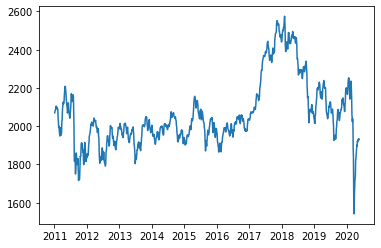

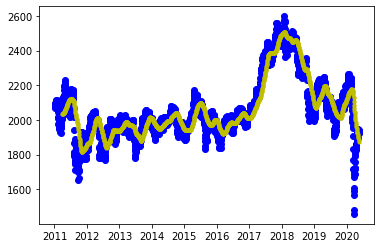

In [93]:
plt.plot(data["Close"],'bo')
plt.plot(y_MA,'y.')

In [102]:
for x in feature_df:
    print(x)

Change_5
Change_10
Change_20
Change_40
Change_60
MA_5
MA_10
MA_20
MA_40
MA_60
HV_60
HV_120
HV_252
Volume
